In [1]:
from scipy.io import loadmat

data = loadmat('emnist-digits.mat')

In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [3]:
dataset = data['dataset'][0, 0]
train = dataset[0][0, 0]  
test = dataset[1][0, 0]  
mapping = dataset[2]

train_images = train['images']   # Shape: (N, 28*28)
train_labels = train['labels']  # Shape: (N, 1)

[0]


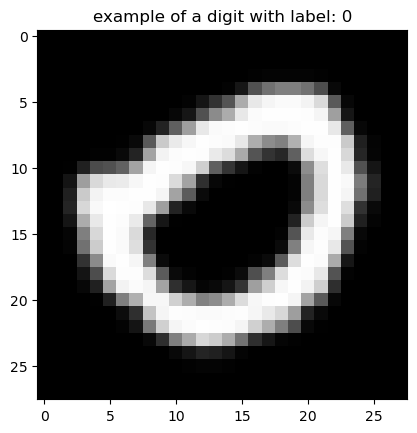

In [4]:
i = 115
img = train_images[i].reshape(28, 28)
print(train_labels[i])
plt.imshow(img, cmap='gray')
plt.title("example of a digit with " +f"label: {train_labels[i][0]}")
plt.show()

In [5]:
print(train.dtype.names)

('images', 'labels', 'writers')


In [6]:
train_writers = train['writers']

In [7]:
print(train_writers[i])

[502]


240000
3579


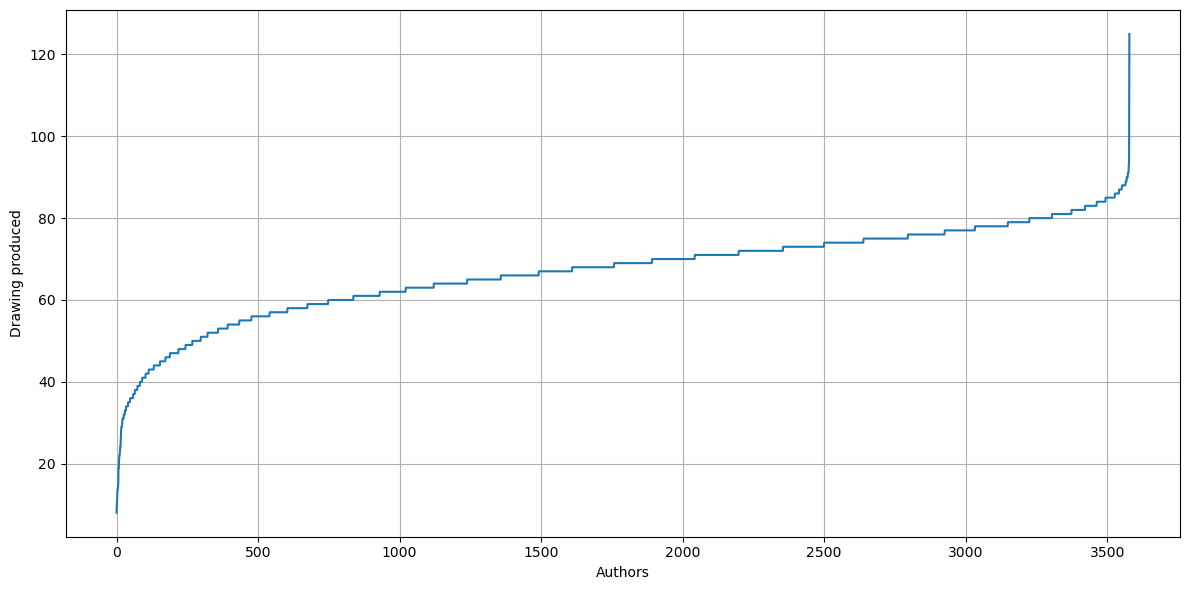

In [8]:
freq = dict()

n = len(train_writers) 
authors = set()
count = dict()
print(n)
for i in range(n):
    author = int(train_writers[i][0])
    count[author] = count.get(author,0) + 1
res = list(count.values())
res.sort(reverse = False)
print(len(res))
plt.figure(figsize=(12, 6))  # Optional: Make the figure larger
plt.plot(res)
plt.xlabel('Authors')
plt.ylabel('Drawing produced')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def gd_step(model, data, target, gamma):
    model.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= gamma * param.grad
    return model

def client_update(model, data, target, K, gamma):
    for _ in range(K):
        model = gd_step(model, data, target, gamma)
    return model

In [12]:
def fedavg(datalist, T, K, gamma):
    n = len(datalist)
    global_model = SimpleNN()
    global_model_state = deepcopy(global_model.state_dict())

    for t in range(T):
        print("round : ", t+1)
        local_states = []
        for i in range(n):
            client_model = SimpleNN()
            client_model.load_state_dict(global_model_state)

            X, y = datalist[i]
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.long)

            client_model = client_update(client_model, X_tensor, y_tensor, K, gamma)
            local_states.append(deepcopy(client_model.state_dict()))
        
        # Federated averaging
        new_global_state = deepcopy(global_model_state)
        for key in global_model_state:
            new_global_state[key] = sum([local_states[i][key] for i in range(n)]) / n
        global_model_state = new_global_state
    
    global_model.load_state_dict(global_model_state)
    return global_model

In [13]:
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_tensor = torch.tensor(y_test, dtype=torch.long)

        outputs = model(X_tensor)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions == y_tensor).float().mean().item()
    return accuracy

In [14]:
X = train_images.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = train_labels.flatten().astype(np.int64)

# Wrap into a datalist with a single client
datalist = [(X, y)]

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# Run FedAvg with 1 client
print("now training the baseline, i.e. fedAvg with one client holding all the data")
model = fedavg(datalist, T, K, gamma)


now training the baseline, i.e. fedAvg with one client holding all the data
round :  1
round :  2
round :  3
round :  4
round :  5


In [15]:
test_images = test['images'].astype(np.float32) / 255.0
test_labels = test['labels'].flatten().astype(np.int64)

test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 84.47%


In [16]:
def create_dirichlet_clients(X, y, n, beta):
    num_classes = 10
    class_indices = [np.where(y == i)[0] for i in range(num_classes)]

    client_data_indices = [[] for _ in range(n)]
    class_counts = [len(indices) for indices in class_indices]

    # For each class, distribute samples to clients using Dirichlet distribution
    for c in range(num_classes):
        indices = class_indices[c]
        np.random.shuffle(indices)
        
        proportions = np.random.dirichlet(np.repeat(beta, n))
        # Scale proportions so that each client gets len(X)//n samples eventually
        proportions = np.array([p * (len(indices) / (len(X) // n)) for p in proportions])
        proportions = (proportions / proportions.sum()).clip(0, 1)
        splits = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        split_indices = np.split(indices, splits)

        for i, client_idxs in enumerate(split_indices):
            client_data_indices[i].extend(client_idxs)

    # Truncate or pad to ensure each client has exactly len(X)//n samples
    max_len = len(X) // n
    for i in range(n):
        client_data_indices[i] = client_data_indices[i][:max_len]

    # Form the datalist
    datalist = [(X[indices], y[indices]) for indices in client_data_indices]
    return datalist

In [17]:
n_clients = 5
beta = 0.5 
datalist = create_dirichlet_clients(X, y, n_clients, beta)

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print("case with 5 clients, beta=0.5 skewed distribution!")
model = fedavg(datalist, T, K, gamma)



case with 5 clients, beta=0.5 skewed distribution!
round :  1
round :  2
round :  3
round :  4
round :  5


In [18]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} clients and Dir({beta}): {test_accuracy * 100:.2f}%")

Test Accuracy with 5 clients and Dir(0.5): 70.71%


In [19]:
n_clients = 5
beta = 1e5
datalist = create_dirichlet_clients(X, y, n_clients, beta)

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print("case with 5 clients, beta=10^5, which means close to IID clients (baseline 2)!")
model = fedavg(datalist, T, K, gamma)


case with 5 clients, beta=10^5, which means close to IID clients (baseline 2)!
round :  1
round :  2
round :  3
round :  4
round :  5


In [20]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} clients and Dir({beta}): {test_accuracy * 100:.2f}%")

Test Accuracy with 5 clients and Dir(100000.0): 84.61%


In [ ]:
import random
from collections import defaultdict

def make_femnist_datasets(X,y, K=10, seed=42):

    # 1) Group example‐indices by writer
    by_writer = defaultdict(list)
    for idx, writer in enumerate(train['writers']):
        by_writer[int(writer)].append(idx)

    # 2) shuffle writer IDs and split into K groups
    writer_ids = list(by_writer.keys())
    random.seed(seed)
    random.shuffle(writer_ids)
    per = len(writer_ids) // K
    groups = [writer_ids[i*per : (i+1)*per] for i in range(K-1)]
    groups.append(writer_ids[(K-1)*per :])

    # 3) for each group, collect X_i, y_i
    datalist = []
    for group in groups:
        idxs = [i for w in group for i in by_writer[w]]
        Xi = X[idxs]   # shape [n_i, ...]
        yi = y[idxs]   # shape [n_i,]
        datalist.append((Xi, yi))

    return datalist

In [ ]:
n_clients = 5
datalist = make_femnist_datasets(X,y,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print("case with 5 clients, with features distribution shift")
model = fedavg(datalist, T, K, gamma)


[[3315]
 [ 302]
 [2136]
 ...
 [1486]
 [  43]
 [3747]]
3315
302
2136
2511
376
1312
1259
424
2357
1391
3195
1226
2149
2447
3313
1051
1454
2282
1593
434
2195
2593
2478
3823
1416
9
1222
3211
4074
1014
3444
2166
3491
344
3468
221
3268
1593
2544
1203
1082
1635
919
3388
1465
939
1170
1428
468
2081
2013
2329
894
3197
2548
3785
3172
722
889
1848
3387
1747
678
3786
1085
1181
1324
3676
2578
576
672
1607
342
135
2577
2437
3806
945
3108
713
358
373
1151
3404
25
3818
252
1143
1076
874
377
967
3505
1848
242
2376
379
3971
2241
2024
2288
1904
2163
24
2523
3604
3294
1074
407
3638
3943
3125
555
457
1896
502
1307
4086
1427
3172
1339
974
256
539
3144
3628
2522
2511
1217
2301
1389
1016
1678
1354
876
3841
3107
3612
3925
3898
2056
671
1718
3700
1085
57
2578
3333
1926
2540
2040
1847
3285
1861
953
3375
47
1534
906
820
3505
3234
665
4071
443
2022
965
4042
1108
86
753
1905
2270
3480
3964
1384
437
3685
1452
3874
77
320
3184
1808
1088
731
2075
1533
904
1274
1377
1353
1011
3823
2136
981
1300
1298
1963
124
179
4007
1

/tmp/ipykernel_28661/2116124670.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int(writer))
/tmp/ipykernel_28661/2116124670.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  by_writer[int(writer)].append(idx)


3280
429
591
2496
154
1029
1048
169
56
3305
647
2368
3102
2245
2557
3546
1200
1851
1420
168
2489
1947
3743
923
2053
3254
210
3375
1533
1971
3289
2428
2128
1629
2199
3686
75
3279
142
1643
1594
1789
3875
98
2494
371
3719
1857
6
1758
3624
1707
174
338
922
2408
42
1932
2065
822
3558
3859
873
922
110
3786
2542
1560
1745
3437
1298
1652
2402
3410
3977
3559
1553
3717
2385
1166
1162
460
2395
4099
1041
1311
2378
2532
2273
4096
1587
2159
1483
1203
3478
1533
2485
2218
3672
969
2542
3464
3227
2570
1403
4052
3253
1275
744
460
3425
1790
1512
1177
1164
3981
1837
3202
1939
2319
1106
3646
1267
3567
1973
1819
660
1952
775
311
488
4080
1024
373
1736
428
1907
601
1424
2016
1616
2076
3611
366
1175
988
3253
426
1125
2583
3509
1602
2009
1833
4030
1633
3409
1495
1691
2125
3419
3754
1734
3709
618
3356
3539
389
117
817
682
153
3805
722
1182
3955
3151
2021
3137
1585
3502
322
1418
2597
744
138
3831
617
3370
784
974
624
3842
3406
3593
1150
2036
458
1176
586
3691
146
392
4019
2258
3339
3183
2011
1230
350
1953
1948
1

In [23]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 5 ): 84.24%


In [24]:
class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MADE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
    def forward(self, x):
        return torch.sigmoid(self.fc2(F.relu(self.fc1(x))))



class WeightEstimator(nn.Module):
    """
    Estimates the weight α(x) = P(l=1 | u) / (1 - P(l=1 | u))
    based on MADE log-likelihood vectors.
    """
    def __init__(self, input_dim, hidden_dim=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.sigmoid(self.fc2(h)).squeeze(-1)

In [25]:
import torch.nn.functional as F
import torch.optim as optim


def train_local_made(model, loader, epochs=5, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        for x, _ in loader:
            out = model(x)
            loss = F.binary_cross_entropy(out, x)
            opt.zero_grad(); loss.backward(); opt.step()
    return model.state_dict()

def aggregate_models(states, weights):
    return {k: sum(weights[i] * states[i][k] for i in range(len(states)))
            for k in states[0]}

def train_global_made(loaders, dim, hid, rounds=10, local_epochs=1):
    gm = MADE(dim, hid)
    for _ in range(rounds):
        states, sizes = [], []
        for ld in loaders:
            lm = MADE(dim, hid)
            lm.load_state_dict(gm.state_dict())
            sd = train_local_made(lm, ld, epochs=local_epochs)
            states.append(sd); sizes.append(len(ld.dataset))
        total = sum(sizes)
        gm.load_state_dict(aggregate_models(states, [s/total for s in sizes]))
    return gm


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli


def compute_sample_weights(global_made, local_made, loader,
                           device='cpu', num_epochs=1, lr=1e-3):
    """
    Trains the WeightEstimator to distinguish global vs local MADE log-likelihoods
    and computes sample weights α for all samples in loader.

    Args:
        global_made, local_made: MADE models; their forward(x) returns logits for Bernoulli outputs.
        loader: DataLoader yielding (X, _) batches (X in [0,1]).
        device: 'cpu' or 'cuda'.
        num_epochs: number of training epochs for estimator.
        lr: learning rate.

    Returns:
        Tensor of α weights for all samples in order.
    """
    # Determine input dimension
    sample_batch = next(iter(loader))[0].to(device)
    with torch.no_grad():
        logits = global_made(sample_batch)
    input_dim = logits.size(1)

    estimator = WeightEstimator(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(estimator.parameters(), lr=lr)

    # Train
    estimator.train()
    for _ in range(num_epochs):
        for X, _ in loader:
            X = X.to(device)
            X_bin = (X >= 0.5).float()
            with torch.no_grad():
                ug = Bernoulli(logits=global_made(X)).log_prob(X_bin)
                ul = Bernoulli(logits=local_made(X)).log_prob(X_bin)
            U = torch.cat([ug, ul], dim=0)
            labels = torch.cat([
                torch.zeros(ug.size(0)),
                torch.ones(ul.size(0))
            ]).to(device)
            preds = estimator(U)
            loss = criterion(preds, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    # Compute α for each sample
    estimator.eval()
    alphas = []
    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            X_bin = (X >= 0.5).float()
            ul = Bernoulli(logits=local_made(X)).log_prob(X_bin)
            p = estimator(ul)
            alphas.append((p / (1 - p)).cpu())
    return torch.cat(alphas)




In [29]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# 1) Create MADE data loaders
made_loaders = [
    DataLoader(
        TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.zeros(len(X), dtype=torch.float32)
        ),
        batch_size=64,
        shuffle=True
    )
    for X, _ in datalist
]

# 2) Train global MADE
global_made = train_global_made(
    made_loaders,
    dim=28*28,
    hid=100,
    rounds=T,
    local_epochs=1
)

# 3) Compute sample‐weights α for each client
sample_weights = []
for ld in made_loaders:
    # train local MADE and load its weights
    local_made = MADE(28*28, 100)
    local_state = train_local_made(local_made, ld, epochs=1)
    local_made.load_state_dict(local_state)

    # compute α for this client (Tensor of shape [n_samples])
    alpha = compute_sample_weights(global_made, local_made, ld)
    sample_weights.append(alpha)

# 4) Build weighted datasets by oversampling
weighted_datalist = []
for (Xi, yi), a in zip(datalist, sample_weights):
    # normalize and scale to counts, then convert to numpy ints
    counts = (a / a.sum() * len(yi)).cpu().numpy().astype(int)
    idxs = np.repeat(np.arange(len(yi)), counts)
    weighted_datalist.append((Xi[idxs], yi[idxs]))

# 5) Federated training on weighted data
print("case with 5 clients, with feature distribution shift")
model = fedavg(weighted_datalist, T, K, gamma)


case with 5 clients, with feature distribution shift
round :  1
round :  2
round :  3
round :  4
round :  5


In [30]:

test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 5 ): 84.12%
